In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import os
import sys

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime


transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

# Create datasets for training & validation, download if necessary
training_set = torchvision.datasets.FashionMNIST(
    "./data", train=True, transform=transform, download=True
)
validation_set = torchvision.datasets.FashionMNIST(
    "./data", train=False, transform=transform, download=True
)

# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True)
validation_loader = torch.utils.data.DataLoader(
    validation_set, batch_size=4, shuffle=False
)

# Class labels
classes = (
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle Boot",
)

# Report split sizes
print("Training set has {} instances".format(len(training_set)))
print("Validation set has {} instances".format(len(validation_set)))

Training set has 60000 instances
Validation set has 10000 instances


Bag  T-shirt/top  T-shirt/top  Sneaker


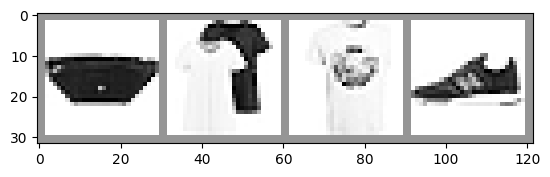

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os


# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))


dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print("  ".join(classes[labels[j]] for j in range(4)))

In [3]:
import torch.nn as nn
import torch.nn.functional as F


# PyTorch models inherit from torch.nn.Module
class GarmentClassifier(nn.Module):
    def __init__(self):
        super(GarmentClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = GarmentClassifier()

In [4]:
loss_fn = torch.nn.CrossEntropyLoss()

# NB: Loss functions expect data in batches, so we're creating batches of 4
# Represents the model's confidence in each of the 10 classes for a given input
dummy_outputs = torch.rand(4, 10)
# Represents the correct class among the 10 being tested
dummy_labels = torch.tensor([1, 5, 3, 7])

print(dummy_outputs)
print(dummy_labels)

loss = loss_fn(dummy_outputs, dummy_labels)
print("Total loss for this batch: {}".format(loss.item()))

tensor([[0.2027, 0.7758, 0.6546, 0.1958, 0.5616, 0.3228, 0.5294, 0.6439, 0.4413,
         0.8575],
        [0.6791, 0.4908, 0.8207, 0.2844, 0.9835, 0.8749, 0.4199, 0.9499, 0.4359,
         0.1692],
        [0.2053, 0.2992, 0.0452, 0.6575, 0.6060, 0.2871, 0.1260, 0.5735, 0.8795,
         0.0504],
        [0.8608, 0.8139, 0.2919, 0.9300, 0.1749, 0.4036, 0.3547, 0.0137, 0.2055,
         0.9752]])
tensor([1, 5, 3, 7])
Total loss for this batch: 2.2622978687286377


In [5]:
loss_fn = torch.nn.CrossEntropyLoss()

# NB: Loss functions expect data in batches, so we're creating batches of 4
# Represents the model's confidence in each of the 10 classes for a given input
dummy_outputs = torch.rand(4, 10)
# Represents the correct class among the 10 being tested
dummy_labels = torch.tensor([1, 5, 3, 7])

print(dummy_outputs)
print(dummy_labels)

loss = loss_fn(dummy_outputs, dummy_labels)
print("Total loss for this batch: {}".format(loss.item()))

tensor([[0.6427, 0.4298, 0.0531, 0.0839, 0.1472, 0.8676, 0.2368, 0.2266, 0.0930,
         0.2592],
        [0.5943, 0.3848, 0.5141, 0.8261, 0.0922, 0.7567, 0.2753, 0.0226, 0.2337,
         0.1361],
        [0.5198, 0.8723, 0.5681, 0.0036, 0.3890, 0.7835, 0.6871, 0.5855, 0.8538,
         0.6751],
        [0.0535, 0.8885, 0.7345, 0.6023, 0.8336, 0.6804, 0.1691, 0.1500, 0.2333,
         0.0490]])
tensor([1, 5, 3, 7])
Total loss for this batch: 2.4350783824920654


In [6]:
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [7]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.0
    last_loss = 0.0

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000  # loss per batch
            print("  batch {} loss: {}".format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar(f"Loss/train", last_loss, tb_x)
            running_loss = 0.0

    return last_loss

In [8]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
writer = SummaryWriter("logs/fashion_trainer_{}".format(timestamp))
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.0

for epoch in range(EPOCHS):
    print("EPOCH {}:".format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)

    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print("LOSS train {} valid {}".format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars(
        "Training vs. Validation Loss",
        {"Training": avg_loss, "Validation": avg_vloss},
        epoch_number + 1,
    )
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = "model_{}_{}".format(timestamp, epoch_number)
        # make models dir
        os.makedirs("models", exist_ok=True)
        # prepend model to model_path
        model_path = os.path.join("models", model_path)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
  batch 1000 loss: 1.71890797868371
  batch 2000 loss: 0.8410614807754755
  batch 3000 loss: 0.7341669770665467
  batch 4000 loss: 0.6507931683054193
  batch 5000 loss: 0.5982694115387276
  batch 6000 loss: 0.5795191136083159
  batch 7000 loss: 0.5587598901305464
  batch 8000 loss: 0.5120745292429346
  batch 9000 loss: 0.5078222500344854
  batch 10000 loss: 0.4637909776595188
  batch 11000 loss: 0.4648534555595834
  batch 12000 loss: 0.445894681220816
  batch 13000 loss: 0.45029449728457255
  batch 14000 loss: 0.4205620481822407
  batch 15000 loss: 0.43219483105896506
LOSS train 0.43219483105896506 valid 0.4624616801738739
EPOCH 2:
  batch 1000 loss: 0.4190816942504607
  batch 2000 loss: 0.42125759257911705
  batch 3000 loss: 0.38344478900998363
  batch 4000 loss: 0.3982890654265648
  batch 5000 loss: 0.37910360554099315
  batch 6000 loss: 0.3976631571915932
  batch 7000 loss: 0.38256783194339367
  batch 8000 loss: 0.369309157315176
  batch 9000 loss: 0.3680702534214943
  batc

In [9]:
saved_model = GarmentClassifier()
saved_model.load_state_dict(torch.load("models/model_20230715_151041_4"))

<All keys matched successfully>

In [10]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models

import captum
from captum.attr import IntegratedGradients, Occlusion, LayerGradCam, LayerAttribution
from captum.attr import visualization as viz

import os, sys
import json

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

AttributeError: module 'matplotlib.cbook' has no attribute '_rename_parameter'